In [35]:
import xarray as xr
import os
#import xesmf as xe
import matplotlib.pyplot as plt
import pandas as pd
import gpflow
import numpy as np
import cartopy.crs as ccrs

In [36]:
# Define input and output directories
input_folder = "~/Quarter2/data/forcing"
output_folder = "/glade/derecho/scratch/qzou/aggregated_forcing"
os.makedirs(output_folder, exist_ok=True)

# SSP scenarios to process
experiments = ['picontrol', 'historical', 'ssp126', 'ssp370', 'ssp585']

In [37]:
dfs = []
for exp in experiments:
    if exp in ['historical', 'picontrol']:
        co2 = pd.read_csv(input_folder+f'/co2_{exp}_annual_1850_2014.txt', sep=r'\s+', comment='#', names=['year', 'value'])
        ch4 = pd.read_csv(input_folder+f'/ch4_{exp}_annual_1850_2014.txt', sep=r'\s+', comment='#', names=['year', 'value'])
    else:
        co2 = pd.read_csv(input_folder+f'/co2_{exp}_annual_2015_2100.txt', sep=r'\s+', comment='#', names=['year', 'value'])
        ch4 = pd.read_csv(input_folder+f'/ch4_{exp}_annual_2015_2100.txt', sep=r'\s+', comment='#', names=['year', 'value'])
    df = co2.merge(ch4, on='year').rename(columns={'value_x': 'CO2', 'value_y': 'CH4'})
    df = df.set_index('year')
    dfs.append(df)
picontrol, historical, ssp126, ssp370, ssp585 = dfs

In [38]:
Xtrain = pd.concat([ssp126, ssp370, ssp585])

In [39]:
Ytrain = xr.concat([xr.open_dataset('./inputs/inputs_ssp126.nc'), xr.open_dataset('./inputs/inputs_ssp370.nc'), xr.open_dataset('./inputs/inputs_ssp585.nc')], dim='time')

In [40]:
Ytrain_pr = Ytrain['pr'].values.reshape(-1, 360*720) * 86400

Xtest = historical.iloc[:]
Ytest = xr.open_dataset('./inputs/inputs_historical.nc')
pr_truth = 86400*Ytest['pr']

In [41]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = Xtrain['CO2'].mean(), Xtrain['CO2'].std()
train_CH4_mean, train_CH4_std = Xtrain['CH4'].mean(), Xtrain['CH4'].std()

Xtrain['CO2'] = (Xtrain['CO2'] - train_CO2_mean) / train_CO2_std
Xtrain['CH4'] = (Xtrain['CH4'] - train_CH4_mean) / train_CH4_std

Xtest['CO2'] = (Xtest['CO2'] - train_CO2_mean) / train_CO2_std
Xtest['CH4'] = (Xtest['CH4'] - train_CH4_mean) / train_CH4_std

In [42]:
# Standardize predictand fields
train_pr_mean, train_pr_std = Ytrain_pr.mean(), Ytrain_pr.std()
Ytrain_pr = (Ytrain_pr - train_pr_mean) / train_pr_std

In [43]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0]) # active_dims specifies which dimension the kernel is applied to
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])


kernel = kernel_CO2 + kernel_CH4

In [44]:
np.random.seed(5)

"""
In Gaussian Processes, a mean function represents the "prior mean" or the expected value
of the function at any input point before observing any data. By default, this mean is 
zero, but here a constant mean is set.
"""
mean = gpflow.mean_functions.Constant()

model = gpflow.models.GPR(data=(Xtrain.astype(np.float64), # cast to float64 because gpflow requires numerical stability
                                Ytrain_pr.astype(np.float64)),
                          kernel = kernel,
                          mean_function = mean)

In [45]:
# define optimizer
optimizer = gpflow.optimizers.Scipy()

# train
optimizer.minimize(model.training_loss,
                   variables=model.trainable_variables,
                   options=dict(disp=True, maxiter=1000))

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 22096067.6882485
        x: [ 2.204e+01  4.685e-01  1.560e+00 -5.519e+00 -2.169e+00
             1.753e-02]
      nit: 54
      jac: [ 2.665e+00 -2.796e+01  4.275e-01  1.831e+00  1.597e+02
            -6.192e+01]
     nfev: 69
     njev: 69
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [46]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(Xtest.values) # predicted mean of GP, predicted variance of GP
posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean # transform mean prediction to original scale
posterior_stddev = np.sqrt(standard_posterior_var) * train_pr_std # transform variance prediction to original scale standard deviation

In [47]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [pr_truth.shape[0], 360, 720])
posterior_pr_stddev = np.reshape(posterior_stddev, [pr_truth.shape[0], 360, 720])

posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_stddev, dims=pr_truth.dims, coords=pr_truth.coords)

In [48]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [49]:
# Compute RMSEs
print(f"RMSE at {pr_truth[35]['time'].values}: {get_rmse(pr_truth[35], posterior_pr_data[35])}")
print(f"RMSE at {pr_truth[85]['time'].values}: {get_rmse(pr_truth[85], posterior_pr_data[85])}")
print(f"RMSE {pr_truth[30]['time'].values}-{pr_truth[41]['time'].values-1}: {get_rmse(pr_truth[30:41], posterior_pr_data[30:41]).mean()}")
print(f"RMSE {pr_truth[75]['time'].values}-{pr_truth[-1]['time'].values}: {get_rmse(pr_truth[75:], posterior_pr_data[75:]).mean()}")
print(f"RMSE {pr_truth[-20]['time'].values}-{pr_truth[-1]['time'].values}: {get_rmse(pr_truth[-20:], posterior_pr_data[-20:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(pr_truth[-20:].mean(dim='time'), posterior_pr_data[-20:].mean(dim='time'))}")

RMSE at 1885: 0.6007048149676744
RMSE at 1935: 0.7261081445634775
RMSE 1880-1890: 0.7329047651542527
RMSE 1925-2014: 0.7421244462567093
RMSE 1995-2014: 0.7848074280384953
RMSE average last 20y: 0.2302064406157464


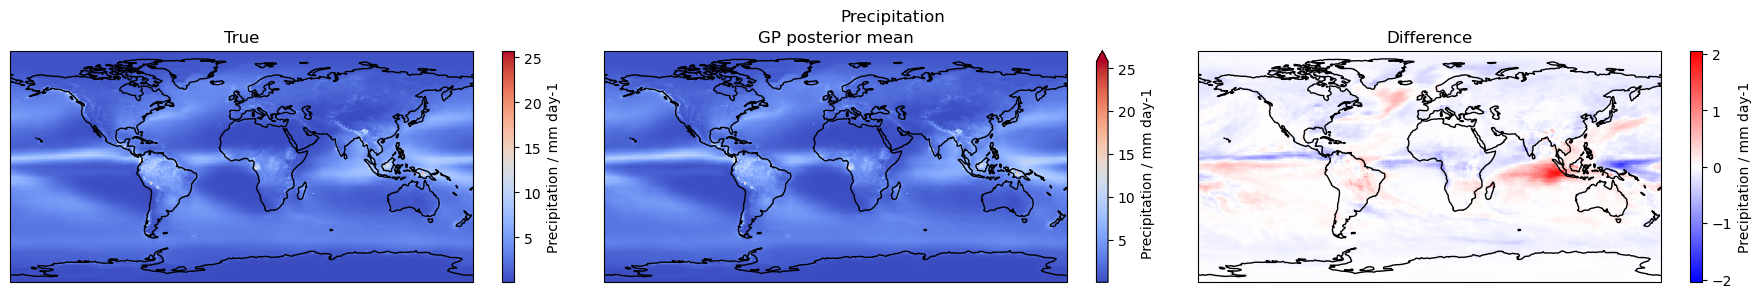

In [61]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors

# Sliced means
truth_mean = pr_truth.sel(time=slice(1950, None)).mean('time')
posterior_mean = posterior_pr_data.sel(time=slice(1950, None)).mean('time')
difference = truth_mean - posterior_mean

# Get ranges
tmin, tmax = float(truth_mean.min()), float(truth_mean.max())
pmin, pmax = float(posterior_mean.min()), float(posterior_mean.max())
dmin, dmax = float(difference.min()), float(difference.max())

# For the truth and posterior plots:
# add a small buffer to make sure you see a gradient in the map
buffer = 0.001  # adjust as needed
vmin_pr = tmin - buffer
vmax_pr = tmax + buffer

# For the difference plot, use a symmetric scale around 0
abs_max_diff = max(abs(dmin), abs(dmax))
diffnorm = colors.TwoSlopeNorm(vcenter=0., vmin=-abs_max_diff, vmax=abs_max_diff)

# Plot
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,3))
fig.suptitle('Precipitation')

# 1) Truth
ax1 = plt.subplot(131, projection=proj)
truth_mean.plot(
    ax=ax1, cmap="coolwarm",
    vmin=vmin_pr, vmax=vmax_pr,
    cbar_kwargs={"label":"Precipitation / mm day-1"}
)
ax1.coastlines()
ax1.set_title('True')

# 2) Posterior
ax2 = plt.subplot(132, projection=proj)
posterior_mean.plot(
    ax=ax2, cmap="coolwarm",
    vmin=vmin_pr, vmax=vmax_pr,
    cbar_kwargs={"label":"Precipitation / mm day-1"}
)
ax2.coastlines()
ax2.set_title('GP posterior mean')

# 3) Difference
ax3 = plt.subplot(133, projection=proj)
difference.plot(
    ax=ax3, cmap="bwr",
    norm=diffnorm,
    cbar_kwargs={"label":"Precipitation / mm day-1"}
)
ax3.coastlines()
ax3.set_title('Difference')

plt.tight_layout()
plt.show()


In [60]:
Ytrain['pr']

<xarray.DataArray 'pr' (time: 258, lat: 360, lon: 720)> Size: 267MB
array([[[5.84643476e-06, 5.87057002e-06, 5.91778007e-06, ...,
         6.01833926e-06, 5.90897116e-06, 5.95133042e-06],
        [6.34617254e-06, 6.40425878e-06, 6.36767936e-06, ...,
         6.42413670e-06, 6.41450379e-06, 6.42938676e-06],
        [6.01898091e-06, 6.01532111e-06, 6.05124615e-06, ...,
         6.05339528e-06, 6.03837771e-06, 6.07275888e-06],
        ...,
        [4.15398404e-07, 4.47777779e-07, 4.38710657e-07, ...,
         4.02004048e-07, 3.82416005e-07, 4.19381024e-07],
        [8.08026869e-07, 8.08288462e-07, 8.01093449e-07, ...,
         7.85713098e-07, 7.86759529e-07, 7.98129179e-07],
        [6.76777631e-07, 6.65058906e-07, 6.72879594e-07, ...,
         6.91856883e-07, 6.82102154e-07, 6.84940062e-07]],

       [[4.63913102e-06, 4.68342705e-06, 4.68153121e-06, ...,
         4.79879918e-06, 4.73590171e-06, 4.76753303e-06],
        [5.16982755e-06, 5.18063371e-06, 5.19679088e-06, ...,
         5.22210803e-06, 5.21388483e-06, 5.22158643e-06],
        [5.08993026e-06, 5.10725522e-06, 5.08019048e-06, ...,
         5.14358862e-06, 5.13691248e-06, 5.14211433e-06],
...
        [7.17431988e-07, 7.22938751e-07, 7.17013506e-07, ...,
         7.02966815e-07, 6.86467160e-07, 7.04623119e-07],
        [1.32251773e-06, 1.30237220e-06, 1.31605304e-06, ...,
         1.29031059e-06, 1.29480111e-06, 1.31456932e-06],
        [8.24167671e-07, 8.32758644e-07, 8.30663964e-07, ...,
         8.42448515e-07, 8.24618610e-07, 8.18693536e-07]],

       [[6.23506412e-06, 6.28389807e-06, 6.21073104e-06, ...,
         6.28732914e-06, 6.25318171e-06, 6.27461350e-06],
        [9.17798116e-06, 9.16257522e-06, 9.18286969e-06, ...,
         9.18560181e-06, 9.18557453e-06, 9.20486855e-06],
        [8.06191292e-06, 8.03901094e-06, 8.13650968e-06, ...,
         8.09718404e-06, 8.14100804e-06, 8.12131566e-06],
        ...,
        [1.23912980e-06, 1.25862664e-06, 1.28338081e-06, ...,
         1.19439915e-06, 1.19007996e-06, 1.20929280e-06],
        [2.40523650e-06, 2.45631827e-06, 2.41631187e-06, ...,
         2.36393612e-06, 2.36264668e-06, 2.40928171e-06],
        [1.64333028e-06, 1.63143091e-06, 1.62565141e-06, ...,
         1.65055701e-06, 1.64543587e-06, 1.66329471e-06]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) int64 2kB 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    units:          kg m-2 s-1